# 概要

このノートブックでは以下の事柄をトライしている。

１．骨格検出モデルMediaPipeを使った手関節の予測

２．手関節座標を使用してオリジナル画像から必要な部分のみを切り抜く

使用するモデルはGoogle社の[MediaPipe](https://developers.google.com/mediapipe/solutions/vision/hand_landmarker)

骨格検出モデルでは古参で決して精度が高いとは言えないが、他のモデルと違って手の関節まで推定できるのが特徴。

また推定速度も他のモデルより圧倒的に速いので実装に組み込む場合も有用になる。

データはこちらの[リンク](https://drive.google.com/drive/folders/1fVGqHB23CzrMbawJJFhjx_-DBgrNfCwP?usp=sharing)を利用するといい。

※MURAのレントゲン写真はMediaPipeが手と認識しなかったので、今回は使えない。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ライブラリインストール

In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 33.6 MB/s eta 0:00:00


In [ ]:
import cv2
import glob
import os
import csv
import mediapipe as mp
from google.colab.patches import cv2_imshow

# 関数の用意

In [ ]:
# 関数を使いやすいように簡素化しておく
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

In [ ]:
# csvを作成する際のカラム名を自動的につける関数
def fields_name():
    # CSVのヘッダを準備
    fields = []
    fields.append('file_name')
    for i in range(21):
        fields.append(str(i)+'_x')
        fields.append(str(i)+'_y')
        fields.append(str(i)+'_z')
    return fields

# メディアパイプのコード

hand-sample-1.jpg
--------処理前-------


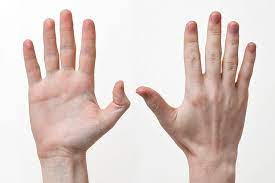

--------処理後-------


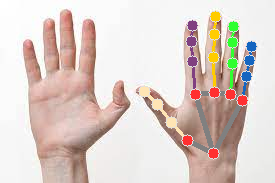

hand-sample-2.jpg
--------処理前-------


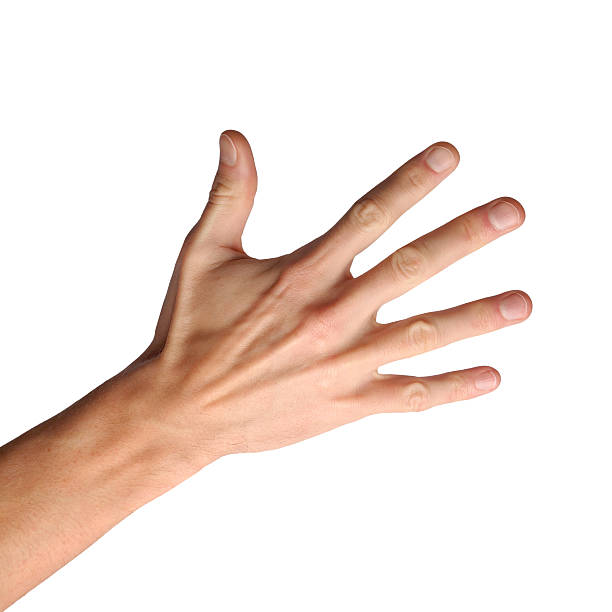

--------処理後-------


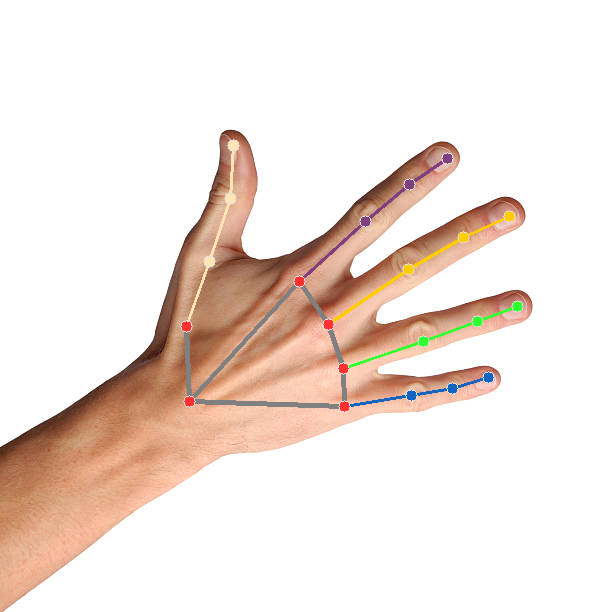

In [ ]:
# if __name__ == '__main__':
# 元の画像ファイルの保存先を準備
resource_dir = r'/content/drive/MyDrive/Colab Notebooks/花岡さん/MediaPipe_Try/Original/'
# 対象画像の一覧を取得
file_list = glob.glob(os.path.join(resource_dir, "*"))

# 保存先の用意
save_csv_dir = '/content/drive/MyDrive/Colab Notebooks/花岡さん/MediaPipe_Try/Prediction/csv/'
os.makedirs(save_csv_dir, exist_ok=True)
save_csv_name = 'landmark.csv'
save_image_dir = '/content/drive/MyDrive/Colab Notebooks/花岡さん/MediaPipe_Try/Prediction/image/'
os.makedirs(save_image_dir, exist_ok=True)

with mp_hands.Hands(static_image_mode=True,
        max_num_hands=1, # 検出する手の数（最大2まで）
        min_detection_confidence=0.5) as hands, \
    open(os.path.join(save_csv_dir, save_csv_name),
        'w', encoding='utf-8', newline="") as f:

    # csv writer の用意
    writer = csv.DictWriter(f, fieldnames=fields_name())
    writer.writeheader()

    for file_path in file_list:
        print(file_path[-17:])
        # 画像の読み込み
        image = cv2.imread(file_path)
        print('--------処理前-------')
        cv2_imshow(image)

        # 鏡写しの状態で処理を行うため反転
        image = cv2.flip(image, 1)

        # OpenCVとMediaPipeでRGBの並びが違うため、
        # 処理前に変換しておく。
        # CV2:BGR → MediaPipe:RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # 推論処理
        results = hands.process(image)

        # 前処理の変換を戻しておく。
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if not results.multi_hand_landmarks:
            # 検出できなかった場合はcontinue
            continue

        # ランドマークの座標情報
        landmarks = results.multi_hand_landmarks[0]

        # CSVに書き込み
        record = {}
        record["file_name"] = os.path.basename(file_path)
        for i, landmark in enumerate(landmarks.landmark):
            record[str(i) + '_x'] = landmark.x
            record[str(i) + '_y'] = landmark.y
            record[str(i) + '_z'] = landmark.z
        writer.writerow(record)

        # 元画像上にランドマークを描画
        mp_drawing.draw_landmarks(
            image,
            landmarks,
            mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())
        # 画像を反転して保存
        image = cv2.flip(image, 1)
        cv2.imwrite(
            os.path.join(save_image_dir, os.path.basename(file_path)),
            image)
        print('--------処理後-------')
        cv2_imshow(image)


# 補足

ランドマークの番号はMediaPipeの公式ドキュメントによりこのように振られている

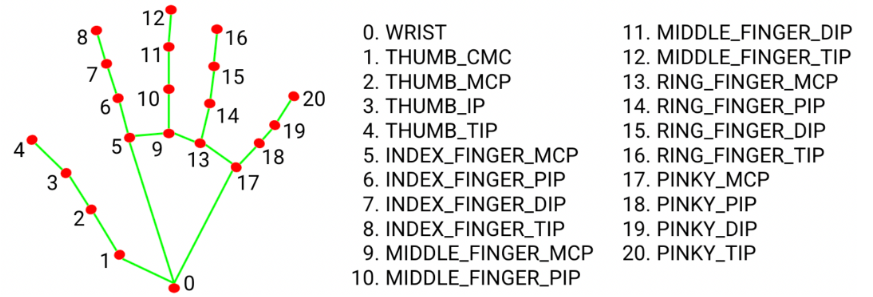

今回切り抜いて行きたいのは

- 1-3

- 5-7

- 9-11

- 13-15

- 17-19

これらの画像を切り抜き、保存していく

In [ ]:
print(landmarks.landmark[0].x)
print(landmarks.landmark[0].y)
image_height, image_width, channel = image.shape
x = image_width-int(landmarks.landmark[0].x*image_width)
y = int(landmarks.landmark[0].y*image_height)
print(x, y)

0.6896867752075195
0.6558972001075745
190 401


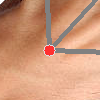

In [ ]:
img2 = image[y-50:y+50, x-50:x+50]
cv2_imshow(img2)

オリジナルもこの座標を使って切り抜きたい

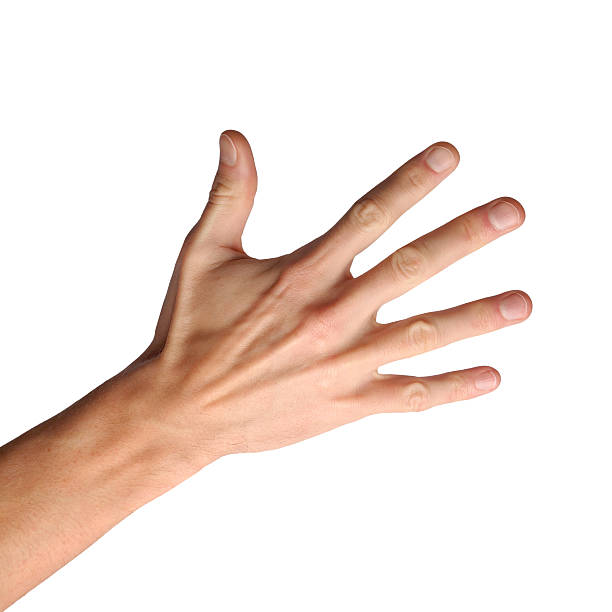

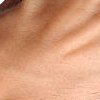

In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/花岡さん/MediaPipe_Try/Original/hand-sample-2.jpg'
img3 = cv2.imread(file_path)
img4 =img3[y-50:y+50, x-50:x+50]
cv2_imshow(img3)
cv2_imshow(img4)

# （最終版）コード

下準備はできた。

後はcsvから各画像のlandmarkを取得後、切り抜いた画像を保存していく。

[処理の流れ]

①ディレクトリ内にある画像を取得

②各画像に対して手の関節を予測させる

③手の画像と予測ポイントを合成した画像を保存

④各予測ポイントごとにクロップし、画像を保存

hand-sample-1.jpg
--------処理前-------


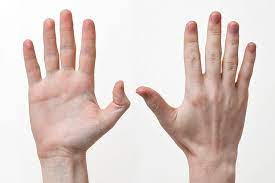

--------処理後-------


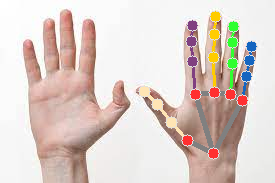

hand-sample-2.jpg
--------処理前-------


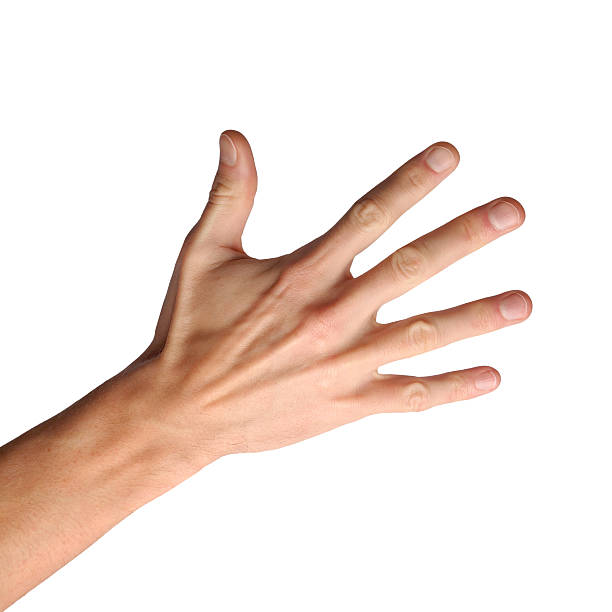

--------処理後-------


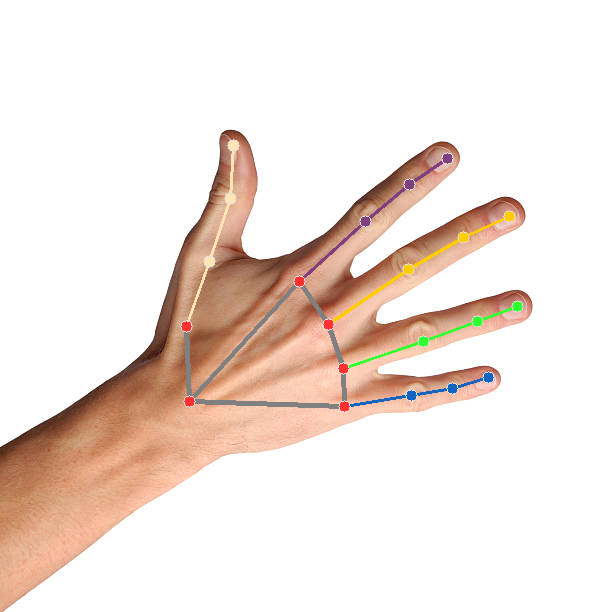

In [ ]:
# if __name__ == '__main__':
# 元の画像ファイルの保存先を準備
resource_dir = r'/content/drive/MyDrive/Colab Notebooks/花岡さん/MediaPipe_Try/Original/'
# 対象画像の一覧を取得
file_list = glob.glob(os.path.join(resource_dir, "*"))

# 保存先の用意
save_csv_dir = '/content/drive/MyDrive/Colab Notebooks/花岡さん/MediaPipe_Try/Prediction/csv/'
os.makedirs(save_csv_dir, exist_ok=True)
save_csv_name = 'landmark.csv'
save_image_dir = '/content/drive/MyDrive/Colab Notebooks/花岡さん/MediaPipe_Try/Prediction/image/'
os.makedirs(save_image_dir, exist_ok=True)

with mp_hands.Hands(static_image_mode=True,
        max_num_hands=1, # 検出する手の数（最大2まで）
        min_detection_confidence=0.5) as hands, \
    open(os.path.join(save_csv_dir, save_csv_name),
        'w', encoding='utf-8', newline="") as f:

    # csv writer の用意
    writer = csv.DictWriter(f, fieldnames=fields_name())
    writer.writeheader()
    count=0
    for file_path in file_list:
        print(file_path[-17:])
        # 画像の読み込み
        image = cv2.imread(file_path)
        print('--------処理前-------')
        cv2_imshow(image)

        # 鏡写しの状態で処理を行うため反転
        image = cv2.flip(image, 1)

        # OpenCVとMediaPipeでRGBの並びが違うため、
        # 処理前に変換しておく。
        # CV2:BGR → MediaPipe:RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # 推論処理
        results = hands.process(image)

        # 前処理の変換を戻しておく。
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if not results.multi_hand_landmarks:
            # 検出できなかった場合はcontinue
            continue

        # ランドマークの座標情報
        landmarks = results.multi_hand_landmarks[0]

        # CSVに書き込み
        record = {}
        record["file_name"] = os.path.basename(file_path)
        for i, landmark in enumerate(landmarks.landmark):
            record[str(i) + '_x'] = landmark.x
            record[str(i) + '_y'] = landmark.y
            record[str(i) + '_z'] = landmark.z
        writer.writerow(record)

        # 元画像上にランドマークを描画
        mp_drawing.draw_landmarks(
            image,
            landmarks,
            mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())
        # 画像を反転して保存
        image = cv2.flip(image, 1)
        cv2.imwrite(
            os.path.join(save_image_dir, os.path.basename(file_path)),
            image)
        print('--------処理後-------')
        cv2_imshow(image)

        # 各Jointの画像を保存していく
        # 今回用意した画像が各々pixel数が違うので、各々でmarginを変える
        if count ==0:
          margin = 10
        else:
          margin = 30
        # ファイル名のディレクトリを作る
        joint_path = '/content/drive/MyDrive/Colab Notebooks/花岡さん/MediaPipe_Try/JointCrop/'+file_path[-17:]
        os.makedirs(joint_path, exist_ok=True)

        # オリジナル画像を読み直す
        image = cv2.imread(file_path)

        # joint名のjpgで保存
        # jointごとにfor文で回す
        for i in range(len(landmarks.landmark)):
          image_height, image_width, channel = image.shape
          x = image_width-int(landmarks.landmark[i].x*image_width)
          y = int(landmarks.landmark[i].y*image_height)
          img2 = image[y-margin:y+margin, x-margin:x+margin]
          cv2.imwrite(joint_path+'/'+str(i)+'.jpg', img2)

        # カウントごとにmarginを変えるので１増やす
        count+=1
